In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import copy

Using TensorFlow backend.


## Load the Fashinon MNIST Dataset

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

In [4]:
train_data.shape

(60000, 28, 28)

In [5]:
train_data.dtype

dtype('uint8')

In [6]:
test_data.shape

(10000, 28, 28)

## Split the Dataset

In [7]:
X_train, X_val, y_train, y_val = train_test_split(train_data, 
                                                  train_labels,
                                                  test_size=0.166,
                                                  stratify=train_labels, 
                                                  random_state=0)

In [8]:
X_train.shape

(50040, 28, 28)

In [9]:
X_val.shape

(9960, 28, 28)

## Normalize the dataset

In [10]:
def normalize_data(data):
    data = data.reshape(data.shape[0],-1)
    data = data.astype('float32') / 255.0
    return data

In [11]:
X_train_full, X_train, X_val, X_test = normalize_data(train_data), normalize_data(X_train), \
                                       normalize_data(X_val), normalize_data(test_data)

## Vectorize the Labels

In [12]:
def vectorize_labels(labels):
    labels = labels = np.array(labels).astype('float32')
    labels = to_categorical(labels)
    return labels

In [13]:
y_train_full, y_train, y_val, y_test = vectorize_labels(train_labels), vectorize_labels(y_train), \
                                       vectorize_labels(y_val), vectorize_labels(test_labels)

## Build the Model

In [14]:
def build_model(learning_rate=2e-3, 
                n_hidden=3, 
                n_neurons=128, 
                input_shape=784, 
                output_shape=10, 
                activation='elu',
                kernel_initializer='he_normal',
                kernel_regularizer=None,
                loss='categorical_crossentropy',
                optimizer=keras.optimizers.Nadam):
    
    model = keras.models.Sequential()
    
    for layer in range(n_hidden):
        if layer == 0:
            model.add(keras.layers.Dense(n_neurons, 
                                         activation=activation, 
                                         kernel_initializer=kernel_initializer,
                                         kernel_regularizer=kernel_regularizer,
                                         input_shape=(input_shape,)))
        else:
            model.add(keras.layers.Dense(n_neurons, 
                                         activation=activation,
                                         kernel_initializer=kernel_initializer,
                                         kernel_regularizer=kernel_regularizer))
            
    model.add(keras.layers.Dense(output_shape, 
                                 activation='softmax',
                                 kernel_initializer='glorot_uniform'))
    
    opt = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    
    return model

## Evaluate Loss Function

In [15]:
losses = ['categorical_crossentropy', 'hinge', 'kullback_leibler_divergence']
histories = []

for loss in losses:
    history = None
    model = None
    model = build_model(loss=loss)
    history = model.fit(X_train,
                        y_train,
                        batch_size=512,
                        epochs=100,
                        validation_data=(X_val, y_val),
                        callbacks=[keras.callbacks.EarlyStopping(patience=2)],
                        verbose=0)
    histories.append(history)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
def plot_model_performance(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss)+1)

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.grid(True)
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show();
    
    plt.clf()

    acc = history.history['acc']
    val_acc = history.history['val_acc']

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.grid(True)
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()

    plt.show();

Loss function: categorical_crossentropy


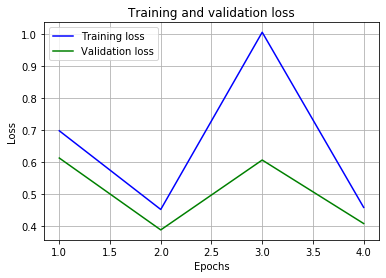

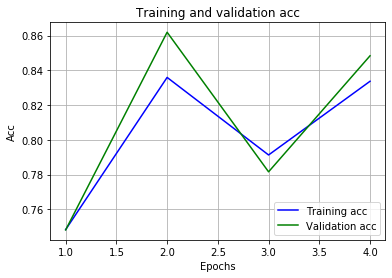

Loss function: hinge


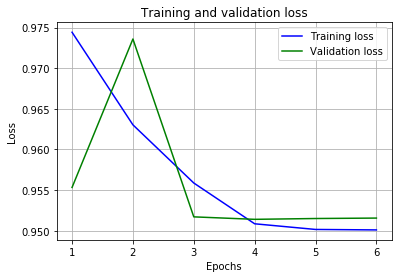

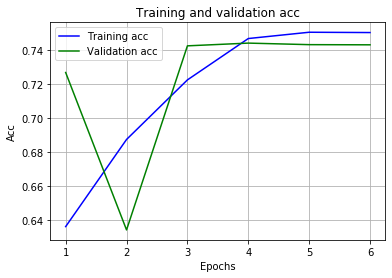

Loss function: kullback_leibler_divergence


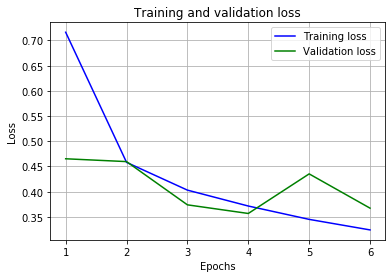

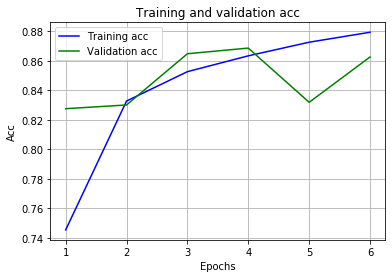

In [19]:
for i, history in enumerate(histories):
    print('Loss function:', losses[i])
    plot_model_performance(history)

## Evaluate Optimizers

In [20]:
optimizers = [keras.optimizers.SGD, keras.optimizers.RMSprop, keras.optimizers.Adagrad, keras.optimizers.Adam]

opt_histories = []

for opt in optimizers:
    history = None
    model = None
    model = build_model(learning_rate=1e-3, optimizer=opt)
    history = model.fit(X_train,
                        y_train,
                        batch_size=512,
                        epochs=100,
                        validation_data=(X_val, y_val),
                        callbacks=[keras.callbacks.EarlyStopping(patience=2)],
                        verbose=0)
    opt_histories.append(history)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Optimizer: <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>


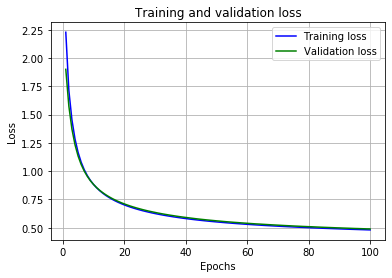

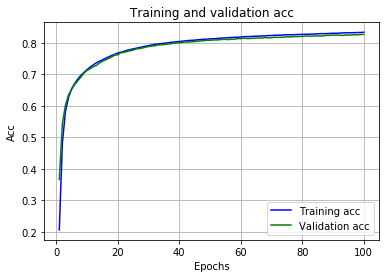

Optimizer: <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>


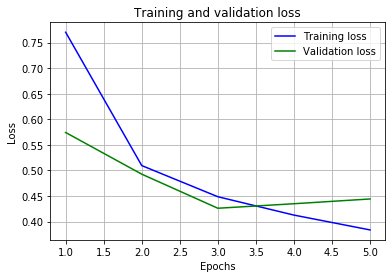

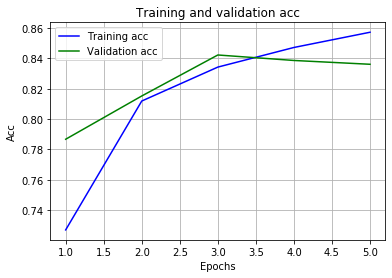

Optimizer: <class 'tensorflow.python.keras.optimizer_v2.adagrad.Adagrad'>


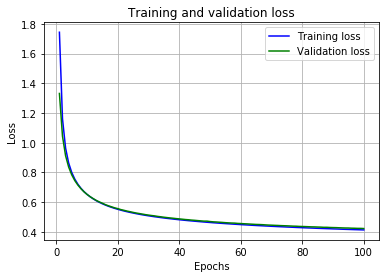

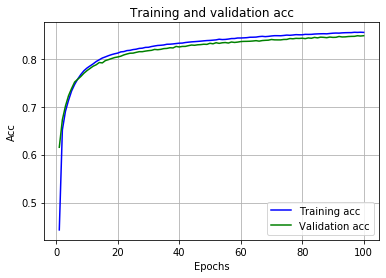

Optimizer: <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>


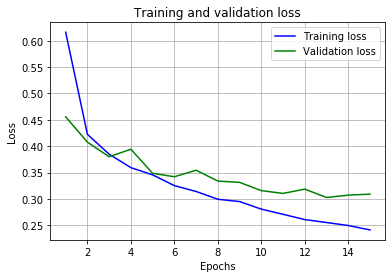

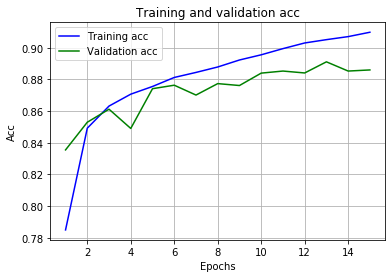

In [21]:
for i, history in enumerate(opt_histories):
    print('Optimizer:', optimizers[i])
    plot_model_performance(history)

## Evaluate Regularization

### Weight decay

#### L1

Train on 50040 samples, validate on 9960 samples
Epoch 1/100
50040/50040 [==============================] - 1s 29us/sample - loss: 6.9096 - acc: 0.7346 - val_loss: 5.3679 - val_acc: 0.7907
Epoch 2/100
50040/50040 [==============================] - 1s 16us/sample - loss: 4.5047 - acc: 0.7973 - val_loss: 3.7801 - val_acc: 0.7663
Epoch 3/100
50040/50040 [==============================] - 1s 15us/sample - loss: 3.2088 - acc: 0.7988 - val_loss: 2.7236 - val_acc: 0.7988
Epoch 4/100
50040/50040 [==============================] - 1s 16us/sample - loss: 2.4043 - acc: 0.8002 - val_loss: 2.1003 - val_acc: 0.8028
Epoch 5/100
50040/50040 [==============================] - 1s 15us/sample - loss: 1.8813 - acc: 0.8038 - val_loss: 1.6867 - val_acc: 0.8102
Epoch 6/100
50040/50040 [==============================] - 1s 15us/sample - loss: 1.5526 - acc: 0.8081 - val_loss: 1.4549 - val_acc: 0.8023
Epoch 7/100
50040/50040 [==============================] - 1s 15us/sample - loss: 1.3335 - acc: 0.8135 - val_lo

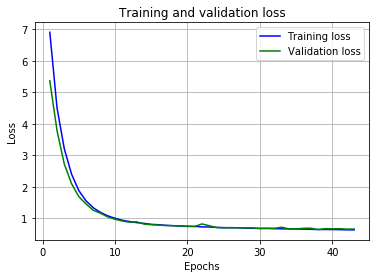

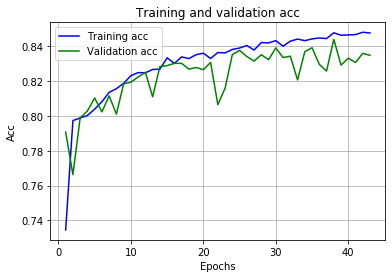

In [31]:
l1_model = build_model(learning_rate=0.001, kernel_regularizer=keras.regularizers.l1(0.001))
l1_history = l1_model.fit(X_train,
                        y_train,
                        batch_size=512,
                        epochs=100,
                        validation_data=(X_val, y_val),
                        callbacks=[keras.callbacks.EarlyStopping(patience=5)],
                        verbose=1)

plot_model_performance(l1_history)

In [32]:
l1_model = build_model(learning_rate=0.001, kernel_regularizer=keras.regularizers.l1(0.001))
l1_history = l1_model.fit(X_train_full,
                        y_train_full,
                        batch_size=512,
                        epochs=39)
l1_model.evaluate(X_test, y_test)

Train on 60000 samples
Epoch 1/39
60000/60000 [==============================] - 1s 19us/sample - loss: 6.6441 - acc: 0.7525
Epoch 2/39
60000/60000 [==============================] - 1s 14us/sample - loss: 4.1162 - acc: 0.8019
Epoch 3/39
60000/60000 [==============================] - 1s 14us/sample - loss: 2.8209 - acc: 0.8001
Epoch 4/39
60000/60000 [==============================] - 1s 14us/sample - loss: 2.0568 - acc: 0.8088
Epoch 5/39
60000/60000 [==============================] - 1s 14us/sample - loss: 1.6062 - acc: 0.8087
Epoch 6/39
60000/60000 [==============================] - 1s 14us/sample - loss: 1.3270 - acc: 0.8144
Epoch 7/39
60000/60000 [==============================] - 1s 14us/sample - loss: 1.1479 - acc: 0.8180
Epoch 8/39
60000/60000 [==============================] - 1s 14us/sample - loss: 1.0273 - acc: 0.8234
Epoch 9/39
60000/60000 [==============================] - 1s 14us/sample - loss: 0.9490 - acc: 0.8237
Epoch 10/39
60000/60000 [==============================] - 

[0.6389202030181885, 0.8409]

#### L2

Train on 50040 samples, validate on 9960 samples
Epoch 1/100
50040/50040 [==============================] - 1s 16us/sample - loss: 0.6015 - acc: 0.8535 - val_loss: 0.5976 - val_acc: 0.8494
Epoch 2/100
50040/50040 [==============================] - 1s 16us/sample - loss: 0.6010 - acc: 0.8520 - val_loss: 0.5907 - val_acc: 0.8510
Epoch 3/100
50040/50040 [==============================] - 1s 16us/sample - loss: 0.5968 - acc: 0.8542 - val_loss: 0.6010 - val_acc: 0.8510
Epoch 4/100
50040/50040 [==============================] - 1s 16us/sample - loss: 0.5938 - acc: 0.8556 - val_loss: 0.6213 - val_acc: 0.8392
Epoch 5/100
50040/50040 [==============================] - 1s 18us/sample - loss: 0.5950 - acc: 0.8546 - val_loss: 0.5949 - val_acc: 0.8493
Epoch 6/100
50040/50040 [==============================] - 1s 16us/sample - loss: 0.5901 - acc: 0.8550 - val_loss: 0.5796 - val_acc: 0.8543
Epoch 7/100
50040/50040 [==============================] - 1s 16us/sample - loss: 0.5888 - acc: 0.8550 - val_lo

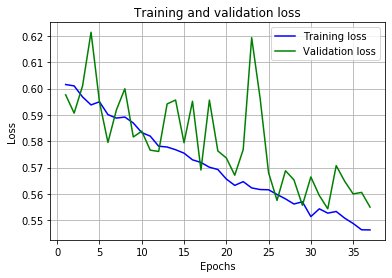

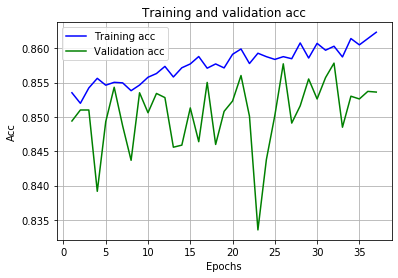

In [33]:
l2_model = build_model(learning_rate=0.001, kernel_regularizer=keras.regularizers.l2(0.001))
l2_history = l1_model.fit(X_train,
                            y_train,
                            batch_size=512,
                            epochs=100,
                            validation_data=(X_val, y_val),
                            callbacks=[keras.callbacks.EarlyStopping(patience=5)],
                            verbose=1)

plot_model_performance(l2_history)

In [34]:
l2_model = build_model(learning_rate=0.001, kernel_regularizer=keras.regularizers.l2(0.001))
l2_history = l2_model.fit(X_train_full,
                            y_train_full,
                            batch_size=512,
                            epochs=32)

l2_model.evaluate(X_test, y_test)

Train on 60000 samples
Epoch 1/32
60000/60000 [==============================] - 1s 19us/sample - loss: 1.3917 - acc: 0.7634
Epoch 2/32
60000/60000 [==============================] - 1s 14us/sample - loss: 1.0772 - acc: 0.8359
Epoch 3/32
60000/60000 [==============================] - 1s 14us/sample - loss: 0.9531 - acc: 0.8490
Epoch 4/32
60000/60000 [==============================] - 1s 14us/sample - loss: 0.8589 - acc: 0.8569
Epoch 5/32
60000/60000 [==============================] - 1s 14us/sample - loss: 0.7843 - acc: 0.8613
Epoch 6/32
60000/60000 [==============================] - 1s 17us/sample - loss: 0.7253 - acc: 0.8655
Epoch 7/32
60000/60000 [==============================] - 1s 14us/sample - loss: 0.6742 - acc: 0.8671
Epoch 8/32
60000/60000 [==============================] - 1s 14us/sample - loss: 0.6358 - acc: 0.8695
Epoch 9/32
60000/60000 [==============================] - 1s 14us/sample - loss: 0.6085 - acc: 0.8684
Epoch 10/32
60000/60000 [==============================] - 

[0.5258049316883087, 0.8426]

### Dropout

Train on 50040 samples, validate on 9960 samples
Epoch 1/100
50040/50040 [==============================] - 2s 33us/sample - loss: 0.8884 - acc: 0.6793 - val_loss: 0.5016 - val_acc: 0.8063
Epoch 2/100
50040/50040 [==============================] - 1s 16us/sample - loss: 0.5857 - acc: 0.7885 - val_loss: 0.4685 - val_acc: 0.8273
Epoch 3/100
50040/50040 [==============================] - 1s 15us/sample - loss: 0.5228 - acc: 0.8110 - val_loss: 0.4180 - val_acc: 0.8419
Epoch 4/100
50040/50040 [==============================] - 1s 16us/sample - loss: 0.4978 - acc: 0.8188 - val_loss: 0.4129 - val_acc: 0.8415
Epoch 5/100
50040/50040 [==============================] - 1s 16us/sample - loss: 0.4704 - acc: 0.8287 - val_loss: 0.3849 - val_acc: 0.8517
Epoch 6/100
50040/50040 [==============================] - 1s 16us/sample - loss: 0.4567 - acc: 0.8332 - val_loss: 0.3704 - val_acc: 0.8605
Epoch 7/100
50040/50040 [==============================] - 1s 16us/sample - loss: 0.4416 - acc: 0.8381 - val_lo

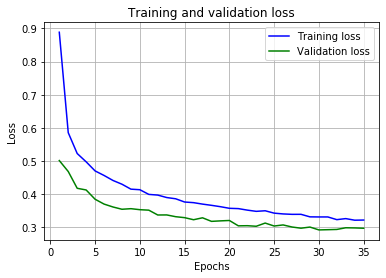

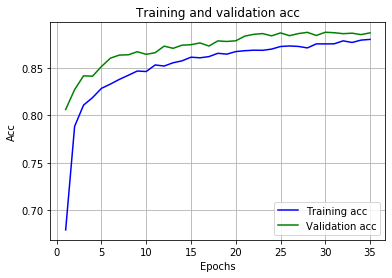

In [35]:
dropout_model = keras.models.Sequential([
    keras.layers.Dropout(0.2, seed=0, input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.2, seed=0),
    keras.layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.2, seed=0),
    keras.layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.2, seed=0),
    keras.layers.Dense(10, activation='softmax')
])

dropout_model.compile(optimizer=keras.optimizers.Nadam(0.001), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

dropout_history = dropout_model.fit(X_train,
                                    y_train,
                                    batch_size=512,
                                    epochs=100,
                                    validation_data=(X_val, y_val),
                                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

plot_model_performance(dropout_history)

In [36]:
dropout_model = keras.models.Sequential([
    keras.layers.Dropout(0.2, seed=0, input_shape=(X_train.shape[1],)),
    keras.layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.2, seed=0),
    keras.layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.2, seed=0),
    keras.layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dropout(0.2, seed=0),
    keras.layers.Dense(10, activation='softmax')
])

dropout_model.compile(optimizer=keras.optimizers.Nadam(0.001), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

dropout_model.fit(X_train_full,
                  y_train_full,
                  batch_size=512,
                  epochs=30)

dropout_model.evaluate(X_test, y_test)

Train on 60000 samples
Epoch 1/30
60000/60000 [==============================] - 1s 21us/sample - loss: 0.8733 - acc: 0.6884
Epoch 2/30
60000/60000 [==============================] - 1s 15us/sample - loss: 0.5688 - acc: 0.7930
Epoch 3/30
60000/60000 [==============================] - 1s 14us/sample - loss: 0.5116 - acc: 0.8156
Epoch 4/30
60000/60000 [==============================] - 1s 15us/sample - loss: 0.4795 - acc: 0.8258
Epoch 5/30
60000/60000 [==============================] - 1s 15us/sample - loss: 0.4564 - acc: 0.8332
Epoch 6/30
60000/60000 [==============================] - 1s 15us/sample - loss: 0.4438 - acc: 0.8372
Epoch 7/30
60000/60000 [==============================] - 1s 15us/sample - loss: 0.4316 - acc: 0.8426
Epoch 8/30
60000/60000 [==============================] - 1s 14us/sample - loss: 0.4168 - acc: 0.8465
Epoch 9/30
60000/60000 [==============================] - 1s 15us/sample - loss: 0.4146 - acc: 0.8470
Epoch 10/30
60000/60000 [==============================] - 

[0.33107448365688324, 0.8808]

### Batch Normalization

Train on 50040 samples, validate on 9960 samples
Epoch 1/100
50040/50040 [==============================] - 2s 48us/sample - loss: 0.8140 - acc: 0.7972 - val_loss: 0.8339 - val_acc: 0.8061
Epoch 2/100
50040/50040 [==============================] - 1s 23us/sample - loss: 0.5867 - acc: 0.8618 - val_loss: 0.6755 - val_acc: 0.8402
Epoch 3/100
50040/50040 [==============================] - 1s 23us/sample - loss: 0.5098 - acc: 0.8776 - val_loss: 0.6175 - val_acc: 0.8391
Epoch 4/100
50040/50040 [==============================] - 1s 25us/sample - loss: 0.4577 - acc: 0.8848 - val_loss: 0.4948 - val_acc: 0.8637
Epoch 5/100
50040/50040 [==============================] - 1s 24us/sample - loss: 0.4154 - acc: 0.8922 - val_loss: 0.4498 - val_acc: 0.8740
Epoch 6/100
50040/50040 [==============================] - 1s 25us/sample - loss: 0.3823 - acc: 0.8979 - val_loss: 0.4636 - val_acc: 0.8616
Epoch 7/100
50040/50040 [==============================] - 1s 24us/sample - loss: 0.3537 - acc: 0.9034 - val_lo

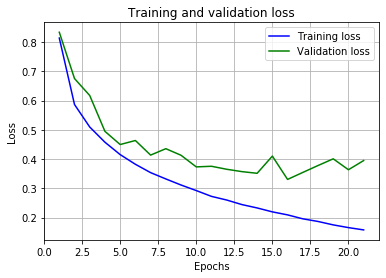

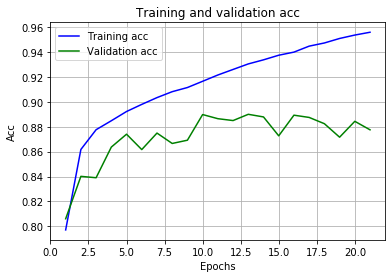

In [37]:
bn_model = keras.models.Sequential()

bn_model.add(keras.layers.Dense(128, kernel_initializer='he_normal', 
                                use_bias=False, input_shape=(X_train.shape[1],)))
bn_model.add(keras.layers.BatchNormalization())
bn_model.add(keras.layers.Activation('elu'))

bn_model.add(keras.layers.Dense(128, kernel_initializer='he_normal', use_bias=False))
bn_model.add(keras.layers.BatchNormalization())
bn_model.add(keras.layers.Activation('elu'))

bn_model.add(keras.layers.Dense(128, kernel_initializer='he_normal', use_bias=False))
bn_model.add(keras.layers.BatchNormalization())
bn_model.add(keras.layers.Activation('elu'))

bn_model.add(keras.layers.Dense(10, kernel_initializer='he_normal', use_bias=False))
bn_model.add(keras.layers.BatchNormalization())
bn_model.add(keras.layers.Activation('softmax'))

bn_model.compile(optimizer=keras.optimizers.Nadam(0.001), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

bn_history = bn_model.fit(X_train,
                          y_train,
                          batch_size=512,
                          epochs=100,
                          validation_data=(X_val, y_val),
                          callbacks=[keras.callbacks.EarlyStopping(patience=5)])

plot_model_performance(bn_history)

In [39]:
bn_model = keras.models.Sequential()

bn_model.add(keras.layers.Dense(128, kernel_initializer='he_normal', 
                                use_bias=False, input_shape=(X_train.shape[1],)))
bn_model.add(keras.layers.BatchNormalization())
bn_model.add(keras.layers.Activation('elu'))

bn_model.add(keras.layers.Dense(128, kernel_initializer='he_normal', use_bias=False))
bn_model.add(keras.layers.BatchNormalization())
bn_model.add(keras.layers.Activation('elu'))

bn_model.add(keras.layers.Dense(128, kernel_initializer='he_normal', use_bias=False))
bn_model.add(keras.layers.BatchNormalization())
bn_model.add(keras.layers.Activation('elu'))

bn_model.add(keras.layers.Dense(10, kernel_initializer='he_normal', use_bias=False))
bn_model.add(keras.layers.BatchNormalization())
bn_model.add(keras.layers.Activation('softmax'))

bn_model.compile(optimizer=keras.optimizers.Nadam(0.001), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

bn_model.fit(X_train_full,
             y_train_full,
             batch_size=512,
             epochs=16)

bn_model.evaluate(X_test, y_test)

Train on 60000 samples
Epoch 1/16
60000/60000 [==============================] - 2s 38us/sample - loss: 0.7775 - acc: 0.8102
Epoch 2/16
60000/60000 [==============================] - 2s 27us/sample - loss: 0.5650 - acc: 0.8650
Epoch 3/16
60000/60000 [==============================] - 1s 22us/sample - loss: 0.4874 - acc: 0.8784
Epoch 4/16
60000/60000 [==============================] - 2s 25us/sample - loss: 0.4325 - acc: 0.8885
Epoch 5/16
60000/60000 [==============================] - 2s 26us/sample - loss: 0.3929 - acc: 0.8947
Epoch 6/16
60000/60000 [==============================] - 2s 27us/sample - loss: 0.3615 - acc: 0.9011
Epoch 7/16
60000/60000 [==============================] - 2s 28us/sample - loss: 0.3358 - acc: 0.9054
Epoch 8/16
60000/60000 [==============================] - 1s 24us/sample - loss: 0.3138 - acc: 0.9096
Epoch 9/16
60000/60000 [==============================] - 1s 23us/sample - loss: 0.2958 - acc: 0.9133
Epoch 10/16
60000/60000 [==============================] - 

[0.44852313675880434, 0.8552]

### Drop + Batch Normalization

Train on 50040 samples, validate on 9960 samples
Epoch 1/100
50040/50040 [==============================] - 3s 61us/sample - loss: 3.9310 - acc: 0.6232 - val_loss: 0.6634 - val_acc: 0.8111
Epoch 2/100
50040/50040 [==============================] - 1s 27us/sample - loss: 3.6883 - acc: 0.6823 - val_loss: 0.5739 - val_acc: 0.8374
Epoch 3/100
50040/50040 [==============================] - 1s 27us/sample - loss: 3.6728 - acc: 0.6903 - val_loss: 0.5401 - val_acc: 0.8441
Epoch 4/100
50040/50040 [==============================] - 1s 27us/sample - loss: 3.6288 - acc: 0.6960 - val_loss: 0.4890 - val_acc: 0.8522
Epoch 5/100
50040/50040 [==============================] - 1s 29us/sample - loss: 3.5799 - acc: 0.7029 - val_loss: 0.4745 - val_acc: 0.8611
Epoch 6/100
50040/50040 [==============================] - 2s 32us/sample - loss: 3.5968 - acc: 0.7024 - val_loss: 0.4584 - val_acc: 0.8600
Epoch 7/100
50040/50040 [==============================] - 1s 27us/sample - loss: 3.5201 - acc: 0.7094 - val_lo

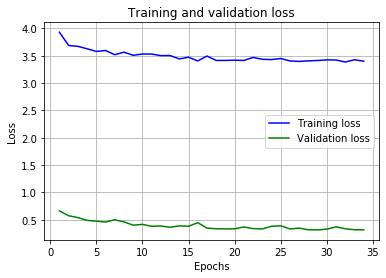

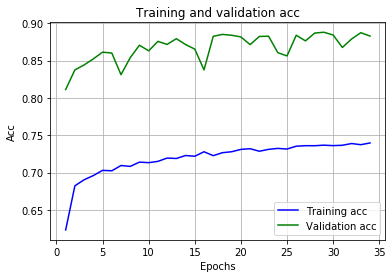

In [40]:
bn_dp_model = keras.models.Sequential()

bn_dp_model.add(keras.layers.Dense(128, kernel_initializer='he_normal', 
                                use_bias=False, input_shape=(X_train.shape[1],)))
bn_dp_model.add(keras.layers.BatchNormalization())
bn_dp_model.add(keras.layers.Activation('elu'))
bn_dp_model.add(keras.layers.Dropout(0.2, seed=0))

bn_dp_model.add(keras.layers.Dense(128, kernel_initializer='he_normal', use_bias=False))
bn_dp_model.add(keras.layers.BatchNormalization())
bn_dp_model.add(keras.layers.Activation('elu'))
bn_dp_model.add(keras.layers.Dropout(0.2, seed=0))

bn_dp_model.add(keras.layers.Dense(128, kernel_initializer='he_normal', use_bias=False))
bn_dp_model.add(keras.layers.BatchNormalization())
bn_dp_model.add(keras.layers.Activation('elu'))
bn_dp_model.add(keras.layers.Dropout(0.2, seed=0))

bn_dp_model.add(keras.layers.Dense(10, kernel_initializer='he_normal', use_bias=False))
bn_dp_model.add(keras.layers.BatchNormalization())
bn_dp_model.add(keras.layers.Activation('softmax'))
bn_dp_model.add(keras.layers.Dropout(0.2, seed=0))

bn_dp_model.compile(optimizer=keras.optimizers.Nadam(0.001), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

bn_dp_history = bn_dp_model.fit(X_train,
                          y_train,
                          batch_size=512,
                          epochs=100,
                          validation_data=(X_val, y_val),
                          callbacks=[keras.callbacks.EarlyStopping(patience=5)])

plot_model_performance(bn_dp_history)

In [41]:
bn_dp_model = keras.models.Sequential()

bn_dp_model.add(keras.layers.Dense(128, kernel_initializer='he_normal', 
                                use_bias=False, input_shape=(X_train.shape[1],)))
bn_dp_model.add(keras.layers.BatchNormalization())
bn_dp_model.add(keras.layers.Activation('elu'))
bn_dp_model.add(keras.layers.Dropout(0.2, seed=0))

bn_dp_model.add(keras.layers.Dense(128, kernel_initializer='he_normal', use_bias=False))
bn_dp_model.add(keras.layers.BatchNormalization())
bn_dp_model.add(keras.layers.Activation('elu'))
bn_dp_model.add(keras.layers.Dropout(0.2, seed=0))

bn_dp_model.add(keras.layers.Dense(128, kernel_initializer='he_normal', use_bias=False))
bn_dp_model.add(keras.layers.BatchNormalization())
bn_dp_model.add(keras.layers.Activation('elu'))
bn_dp_model.add(keras.layers.Dropout(0.2, seed=0))

bn_dp_model.add(keras.layers.Dense(10, kernel_initializer='he_normal', use_bias=False))
bn_dp_model.add(keras.layers.BatchNormalization())
bn_dp_model.add(keras.layers.Activation('softmax'))
bn_dp_model.add(keras.layers.Dropout(0.2, seed=0))

bn_dp_model.compile(optimizer=keras.optimizers.Nadam(0.001), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

bn_dp_model.fit(X_train,
                y_train,
                batch_size=512,
                epochs=29)

bn_dp_model.evaluate(X_test, y_test)

Train on 50040 samples
Epoch 1/29
50040/50040 [==============================] - 2s 41us/sample - loss: 3.9424 - acc: 0.6162
Epoch 2/29
50040/50040 [==============================] - 1s 24us/sample - loss: 3.7820 - acc: 0.6785
Epoch 3/29
50040/50040 [==============================] - 1s 25us/sample - loss: 3.6804 - acc: 0.6901
Epoch 4/29
50040/50040 [==============================] - 1s 25us/sample - loss: 3.5785 - acc: 0.6994
Epoch 5/29
50040/50040 [==============================] - 1s 25us/sample - loss: 3.5721 - acc: 0.7023
Epoch 6/29
50040/50040 [==============================] - 1s 25us/sample - loss: 3.5808 - acc: 0.7055
Epoch 7/29
50040/50040 [==============================] - 1s 25us/sample - loss: 3.5732 - acc: 0.7054
Epoch 8/29
50040/50040 [==============================] - 1s 25us/sample - loss: 3.5386 - acc: 0.7088
Epoch 9/29
50040/50040 [==============================] - 1s 25us/sample - loss: 3.5235 - acc: 0.7128
Epoch 10/29
50040/50040 [==============================] - 

[0.3638706891298294, 0.8722]

### Ensemble Classifier

#### Ensemble classfier predictions

In [42]:
l1_pred = l1_model.predict(X_test)
l2_pred = l2_model.predict(X_test)
dropout_pred = dropout_model.predict(X_test)
bn_pred = bn_model.predict(X_test)
bn_dp_pred = bn_dp_model.predict(X_test)

ensemble_pred = np.argmax(l1_pred + l2_pred + dropout_pred + bn_pred + bn_dp_pred, axis=1)
np.mean(ensemble_pred.reshape(-1,1) == np.argmax(y_test, axis=1).reshape(-1,1))

0.8852

#### Random guessing

In [45]:
# This code is copied from Deep Learning with python book
np.random.seed(0)
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.099